# Separate the filaments in N2Hp

We know that the filament forks from south to north. Then, we know that there are two components that overlap each other. These correspond to two apparent layers in velocity, as suggested by the KDE of the velocities 

We will first separate the 1 Gaussian fit into the two sides of the filament. Testing DBSCAN, KMEANS, HDBSCAN

In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import os
import sys
sys.path.append('../')
from setup import *
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
%matplotlib widget

from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
seed = 42

In [2]:
# we first generate our table of features
mol1 = 'N2Hp'
n2hp_as_features_file = bayesfolder + 'nested-sampling/{0}/{0}_feature_table_bayes.csv'.format(mol1)
mol1label = r'N$_2$H$^+$'
ncomp1 = 2
ncompfilebayes_mol1 = bayesfolder + 'nested-sampling/'+mol1+'/npeaks_cut5.fits'.format(mol1)

ds_mol1_feats = pd.read_csv(n2hp_as_features_file, index_col=0)
print('We have ', np.shape(ds_mol1_feats)[0], 'points')

We have  99512 points


In [3]:
# we select which columns we want to separate by
ds_cluster1 = ds_mol1_feats[['x_pix', 'y_pix', 'amplitude', 'vlsr', 'sigma_v']]
ds_cluster2 = ds_mol1_feats[['x_pix', 'y_pix', 'vlsr']]

In [4]:
scaler1 = StandardScaler()
X1 = scaler1.fit_transform(ds_cluster1)
scaler2 = StandardScaler()
X2 = scaler2.fit_transform(ds_cluster2)

## KMeans

In [5]:
# lets test a kmeans with 2 groups first
kmeans = KMeans(n_clusters=2, random_state=seed)
kmeans.fit(X1)
ds_cluster1['labels_kmeans'] = kmeans.labels_

/home/mvaldivi/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_14948/1069493364.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cluster1['labels_kmeans'] = kmeans.labels_


<AxesSubplot: xlabel='x_pix', ylabel='y_pix'>

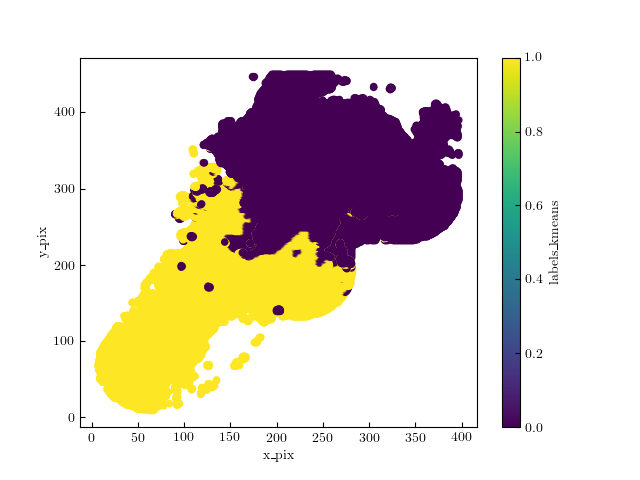

In [6]:
ds_cluster1.plot.scatter(x='x_pix', y='y_pix', c='labels_kmeans', colormap='viridis')

Well, that didn't work.

In [7]:
kmeans2 = KMeans(n_clusters=2, random_state=seed)
kmeans2.fit(X2)
ds_cluster2['labels_kmeans'] = kmeans2.labels_

/home/mvaldivi/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_14948/100427673.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cluster2['labels_kmeans'] = kmeans2.labels_


<AxesSubplot: xlabel='x_pix', ylabel='y_pix'>

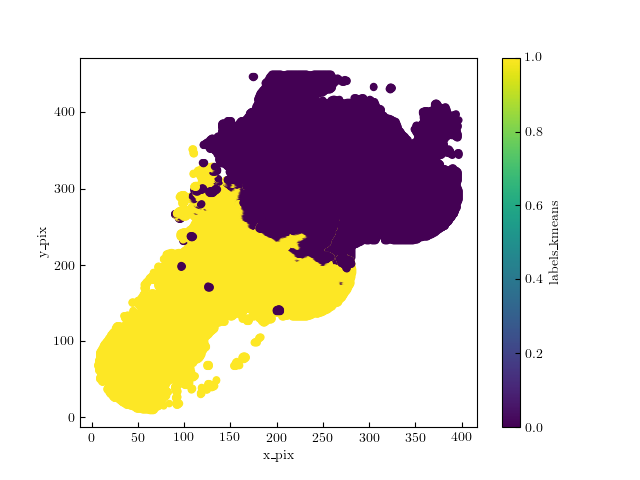

In [8]:
ds_cluster2.plot.scatter(x='x_pix', y='y_pix', c='labels_kmeans', colormap='viridis')

## DBSCAN

In [9]:
min_samples = 1000

In [10]:
# average distance between each point and its k nearest neighbors
# neighbors = NearestNeighbors(n_neighbors=min_samples, algorithm='kd_tree')
# neighbors.fit(X2)
# distances, indices = neighbors.kneighbors(X2)
# distances = np.sort(distances, axis=0)
# distances = distances[:,1]

In [11]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(distances)
# ax.set_xlabel('Points sorted by k-distance')
# ax.set_ylabel('Average distance to k='+str(min_samples)+' nearest neighbors')

We found a good set of parameters for DBSCAN: epsilon =0.35, minsamples = 1000, gives 3 groups and noise looks reasonable

In [12]:
db = DBSCAN(eps=0.352, min_samples=min_samples)
    
db.fit(X2)
labels = db.labels_
ds_cluster2['labels_dbscan'] = labels
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Total number of points: %d" % len(labels))
# unique_labels = set(labels)

Estimated number of clusters: 3
Estimated number of noise points: 7433
Total number of points: 99512


/tmp/ipykernel_14948/3698359756.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cluster2['labels_dbscan'] = labels


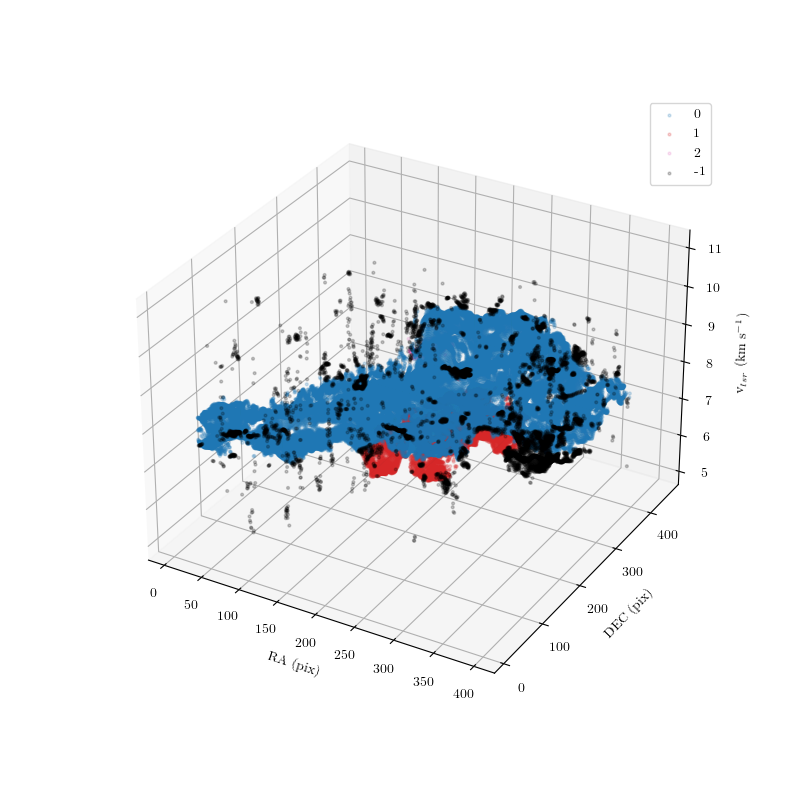

In [13]:
unique_labels = set(labels)
colors = [plt.cm.tab10(each) for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('RA (pix)')
ax.set_ylabel('DEC (pix)')
ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        # continue
    class_member_mask = labels == k

    xy = scaler2.inverse_transform(X2[class_member_mask])
    ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
# ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
ax.legend()

## HDBSCAN

In [19]:
min_samples_hdb = 500

In [20]:
hdb = HDBSCAN(min_cluster_size = min_samples_hdb)
hdb.fit(X2)

labelshdb = hdb.labels_
ds_cluster2['labels_hdbscan'] = labelshdb

/tmp/ipykernel_14948/2474280261.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cluster2['labels_hdbscan'] = labelshdb


In [21]:
n_clusters_ = len(set(labelshdb)) - (1 if -1 in labelshdb else 0)
n_noise_ = list(labelshdb).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Total number of points: %d" % len(labelshdb))

Estimated number of clusters: 2
Estimated number of noise points: 13275
Total number of points: 99512


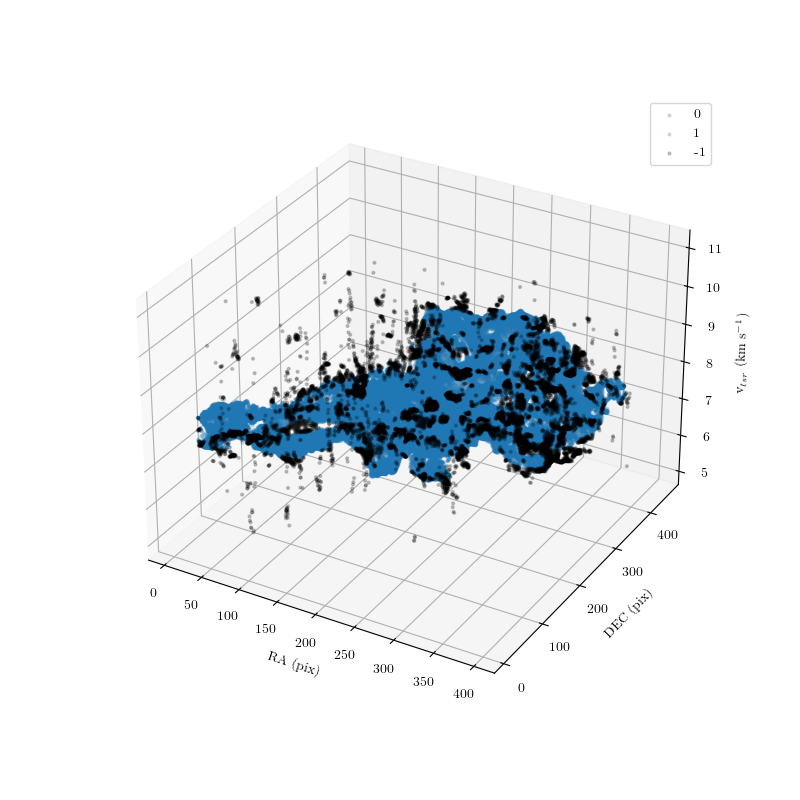

In [22]:
unique_labels = set(labelshdb)
colors = [plt.cm.tab10(each) for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('RA (pix)')
ax.set_ylabel('DEC (pix)')
ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        # continue
    class_member_mask = labelshdb == k

    xy = scaler2.inverse_transform(X2[class_member_mask])
    ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
# ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
ax.legend()